In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, log_loss
from xgboost import XGBClassifier
from sklearn.base import TransformerMixin,BaseEstimator
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline



In [35]:
# 加载数据集A
heart_2020_cleaned = pd.read_csv('/Users/taijieshengwu/2024Research_SU/Data/2020/heart_2020_cleaned.csv')
print(heart_2020_cleaned.shape)
X_2020 = heart_2020_cleaned.drop('HeartDisease', axis=1)
y_2020 = heart_2020_cleaned['HeartDisease']
y_2020 = y_2020.map({'Yes':1,'No':0})

# 加载数据集B
heart_2022 = pd.read_csv('/Users/taijieshengwu/2024Research_SU/Data/2022/heart_2022_no_nans.csv')
print(heart_2022.shape)
X_2022 = heart_2022.drop('HadHeartAttack', axis=1)
y_2022 = heart_2022['HadHeartAttack']
y_2022 = y_2022.map({'Yes':1,'No':0})

# 加载数据集C（假设结构类似于数据集B）
heart = pd.read_csv('/Users/taijieshengwu/2024Research_SU/Data/heart.csv')
print(heart.shape)
X_heart = heart.drop('output', axis=1)
y_heart = heart['output']


(319795, 18)
(246022, 40)
(303, 14)


In [40]:
class CustomCategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ordinal_encoder = OrdinalEncoder()
    
    def fit(self, X, y=None):
        self.ordinal_encoder.fit(X)
        return self
    
    def transform(self, X):
        X_ordinal = self.ordinal_encoder.transform(X)
        return OneHotEncoder(sparse_output=False).fit_transform(X_ordinal)

def create_pipeline(X, y, model):
    # 确定特征类型
    categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', CustomCategoricalTransformer(), categorical_features)
        ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)  # 确保这是一个回归模型
    ])

    # 拆分数据集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    from sklearn.metrics import mean_squared_error

    # 计算 RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse




heart_2020-Testing model: Logistic Regression
Logistic Regression - RMSE: 0.2924076712724063
heart_2020-Testing model: Decision Tree
Decision Tree - RMSE: 0.3696751987232849
heart_2020-Testing model: Random Forest
Random Forest - RMSE: 0.3126160027139646
heart_2020-Testing model: XGBoost
XGBoost - RMSE: 0.29263928134537076
heart_2022-Testing model: Logistic Regression
Logistic Regression - RMSE: 0.2266355925064542
heart_2022-Testing model: Decision Tree
Decision Tree - RMSE: 0.2837857759983558
heart_2022-Testing model: Random Forest
Random Forest - RMSE: 0.22576708159014292
heart_2022-Testing model: XGBoost
XGBoost - RMSE: 0.22678499959797116
heart-Testing model: Logistic Regression
Logistic Regression - RMSE: 0.4322189107537832
heart-Testing model: Decision Tree
Decision Tree - RMSE: 0.5135525910130955
heart-Testing model: Random Forest
Random Forest - RMSE: 0.4569367667316877
heart-Testing model: XGBoost
XGBoost - RMSE: 0.4322189107537832


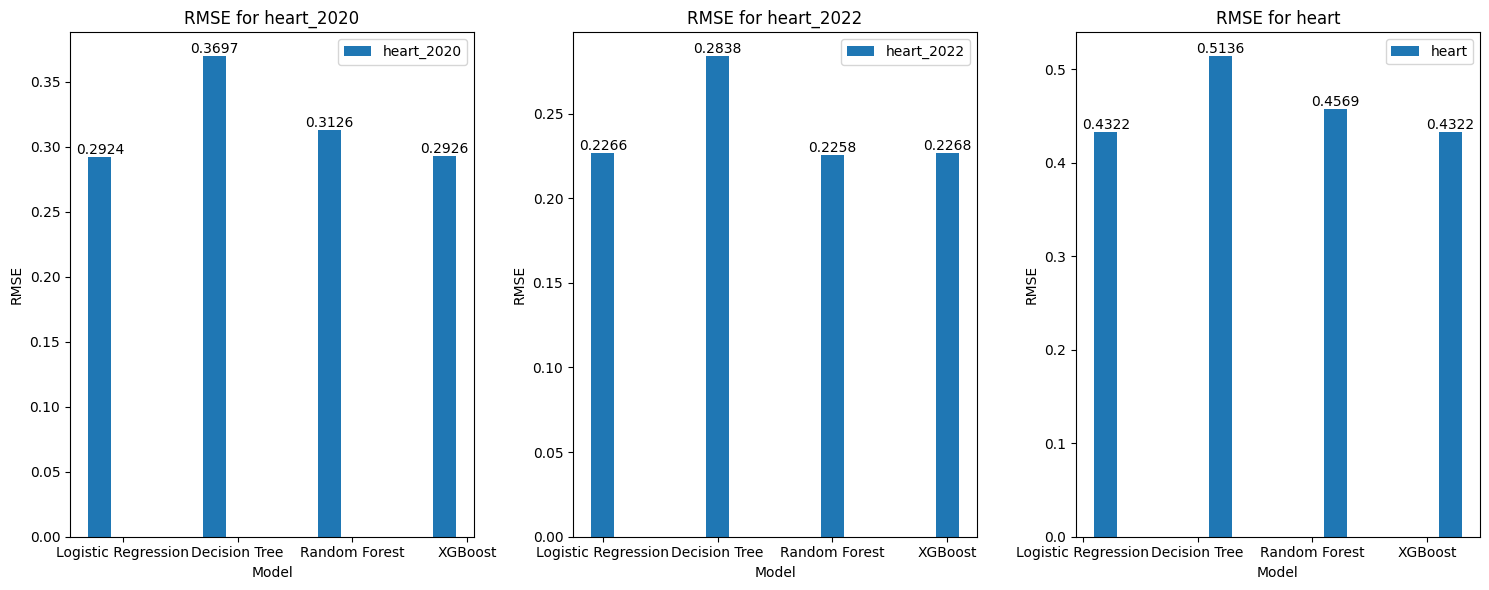

In [43]:
models = { 
    'Logistic Regression': LogisticRegression(), 
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(), 
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss') 
    }
datasets = {
    'heart_2020': (X_2020, y_2020),
    'heart_2022': (X_2022, y_2022),
    'heart': (X_heart, y_heart)
}

rmse_dict = {dataset_name: [] for dataset_name in datasets.keys()}

# 遍历模型和数据集，并计算 RMSE
for dataset_name, (X, y) in datasets.items():
    for name, model in models.items():
        print(f"{dataset_name}-Testing model: {name}")
        rmse = create_pipeline(X, y, model)
        print(f"{name} - RMSE: {rmse}")
        rmse_dict[dataset_name].append(rmse)

# 每个图表的数据
bar_width = 0.2
x_labels = list(models.keys())
x = np.arange(len(x_labels))

# 绘制图表
plt.figure(figsize=(15, 6))

for i, (dataset_name, rmses) in enumerate(rmse_dict.items()):
    plt.subplot(1, 3, i + 1)  # 创建 1 行 3 列的子图
    bars = plt.bar(x + i * bar_width, rmses, width=bar_width, label=dataset_name)

    # 在每个柱子上显示对应的 RMSE 值
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

    # 设置图表参数
    plt.xlabel('Model')
    plt.ylabel('RMSE')
    plt.title(f'RMSE for {dataset_name}')
    plt.xticks(x + bar_width, x_labels)  # 调整 x 轴标签
    plt.legend()

plt.tight_layout()
plt.show()


## question
1. unbalanced dataset leading to the poorer performance to "YES", how to solve

raja: 
undersampling 
smote oversampling, make it balanced
meanwhile control the size of three datasets to make them close


3. we need other models, 
4. in previous study, how do they compare the importance of personal behaviors and accurate numbers


5. how to measure the formance of model,
--regression: rmse
